In [1]:
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git
# !pip install matplotlib pandas
# !pip3 install torch torchvision torchaudio


In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from PIL import Image
from tqdm import tqdm


print("Torch version:", torch.__version__)


/home/ridwan.salahuddeen/.conda/envs/clipenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch version: 1.13.0+cu117


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
# !unzip -o -q ./hateful_memes.zip -d $HOME/.cache/torch/mmf/data/datasets/


In [5]:
!mkdir -p $HOME/.cache/torch/mmf/data/datasets/hateful_memes/defaults/{images,annotations,features/{train,test,val}}
# !mv $HOME/.cache/torch/mmf/data/datasets/hateful_memes/img/* $HOME/.cache/torch/mmf/data/datasets/hateful_memes/defaults/images
# !mv $HOME/.cache/torch/mmf/data/datasets/hateful_memes/*.jsonl $HOME/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/


### Load Hateful Meme Dataset

In [6]:
import os

HOME = os.environ.get("HOME")
images_path = (
    f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/images/img/"
)
annotations_path = (
    f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/"
)
features_path = (
    f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/features/"
)


In [7]:
import pandas as pd

train = pd.read_json(f"{annotations_path}/train.jsonl", lines=True)
dev_seen = pd.read_json(f"{annotations_path}/dev_seen.jsonl", lines=True)
dev_unseen = pd.read_json(f"{annotations_path}/dev_unseen.jsonl", lines=True)
test_seen = pd.read_json(f"{annotations_path}/test_seen.jsonl", lines=True)
test_unseen = pd.read_json(f"{annotations_path}/test_unseen.jsonl", lines=True)


In [8]:
train.head()


,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [9]:
# # Collect all the annotations (from Phase-2)
# train       = pd.read_json(f"{annotations_path}/train.jsonl", lines=True)
# dev_seen    = pd.read_json(f"{annotations_path}/dev_seen.jsonl", lines=True)
# dev_unseen  = pd.read_json(f"{annotations_path}/dev_unseen.jsonl", lines=True)
# test_seen   = pd.read_json(f"{annotations_path}/test_seen.jsonl", lines=True)
# test_unseen = pd.read_json(f"{annotations_path}/test_unseen.jsonl", lines=True)

# Create 2 sets:
#   A set of strings, 'a': for all the image names,
#   A set of lists, 'b': for all the image names in dataset, e.g. train, dev_seen, etc.
a = os.listdir(f"{images_path}")
b = []
for i in [train, dev_seen, dev_unseen, test_seen, test_unseen]:
    b.append(list(i["img"].str.split("/").str.get(1)))

set_mapping = ["train", "dev_seen", "dev_unseen", "test_seen", "test_unseen"]
total_size = 0
print("#of images in: ")
for idx, i in enumerate(b):
    total_size += len(set(i))
    print(f"\t'{set_mapping[idx]}'  \t:", len(set(i)))
else:
    print(
        f"\nIn total there are {total_size} images,",
        "\nBut the # of images in /img/ directory is: ",
        len(a),
    )


#of images in: 
	'train'  	: 8500
	'dev_seen'  	: 500
	'dev_unseen'  	: 540
	'test_seen'  	: 1000
	'test_unseen'  	: 2000

In total there are 12540 images, 
But the # of images in /img/ directory is:  12469


In [10]:
print(
    "#of images that are not in one of the .jsonl files: ",
    len(set(a).symmetric_difference(set(b[0] + b[1] + b[2] + b[3] + b[4]))),
)


#of images that are not in one of the .jsonl files:  329


In [11]:
print("#of same images in between: ")
for i in range(0, 5):
    print("\n")
    for j in range(0, 5):
        if i != j:
            print(
                f"{set_mapping[i], set_mapping[j]}   \t: {len(set(b[i]) & set(b[j]))}"
            )


#of same images in between: 


('train', 'dev_seen')   	: 0
('train', 'dev_unseen')   	: 0
('train', 'test_seen')   	: 0
('train', 'test_unseen')   	: 0


('dev_seen', 'train')   	: 0
('dev_seen', 'dev_unseen')   	: 400
('dev_seen', 'test_seen')   	: 0
('dev_seen', 'test_unseen')   	: 0


('dev_unseen', 'train')   	: 0
('dev_unseen', 'dev_seen')   	: 400
('dev_unseen', 'test_seen')   	: 0
('dev_unseen', 'test_unseen')   	: 0


('test_seen', 'train')   	: 0
('test_seen', 'dev_seen')   	: 0
('test_seen', 'dev_unseen')   	: 0
('test_seen', 'test_unseen')   	: 0


('test_unseen', 'train')   	: 0
('test_unseen', 'dev_seen')   	: 0
('test_unseen', 'dev_unseen')   	: 0
('test_unseen', 'test_seen')   	: 0


`dev_seen` has 100 images not in `dev_unseen`. Merging the 100 images to the train data as follows:

In [12]:
dev_seen.head()

img_100 = set(dev_seen["img"]).difference(dev_unseen["img"])
train_updated = pd.concat([train, dev_seen[dev_seen["img"].isin(img_100)]])
train_updated.to_json(
    f"{annotations_path}/train_updated.jsonl", orient="records", lines=True
)
train.shape, train_updated.shape


((8500, 4), (8600, 4))

## Write the dataset class

In [13]:
train.head(1)


,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters


In [14]:
class HMDataset(Dataset):
    def __init__(
        self,
        images_path: str,
        annotation_path: str,
        features_path=None,
        feature_names_dict: dict = None,
        image_transform=None,
        text_transform=None,
    ) -> None:

        # Try to load features if previously saved and requested. If not saved, fall back to
        self.features_path = features_path
        self.feature_names_dict = feature_names_dict
        # self.images_features, self.text_features, self.labels = None, None, None
        if self.features_path:
            if not self.feature_names_dict:
                self.feature_names_dict = {
                    "image_features": "image_features.pt",
                    "text_features": "text_features.pt",
                    "label_features": "label_features.pt",
                }
                
            try:
                self.images_features = torch.load(f"{features_path}/{self.feature_names_dict['image_features']}")
                self.text_features = torch.load(f"{features_path}/{self.feature_names_dict['text_features']}")
                self.labels = torch.load(f"{features_path}/{self.feature_names_dict['label_features']}")
                return
            except FileNotFoundError as e:
                print(
                    "Unable to load fused_images_and_texts and/or labels from the paths provided. "
                    f"Falling back to loading actual datasets {e}"
                )

        self.images_path = images_path
        self.annotation_path = annotation_path
        self.image_transform = image_transform
        self.text_transform = text_transform
        assert self.annotation_path.endswith(
            ".jsonl"
        ), f"Invalid annotation file format. Format should be '.jsonl', not {self.annotation_path.split('.')[0]}"
        self.annotation: pd.DataFrame = pd.read_json(self.annotation_path, lines=True)

    def __len__(self):
        if hasattr(self, "labels"):
            return self.labels.shape[0]

        return self.annotation.shape[0]

    def __getitem__(self, index):
        if hasattr(self, "images_features") and hasattr(self, "text_features") and hasattr(self, "labels"):
            # print(self.images_features.shape, self.text_features.shape, self.labels.shape)
            return self.images_features[index], self.text_features[index], self.labels[index]

        img_path = os.path.join(self.images_path, self.annotation.loc[index, "img"])
        image = Image.open(img_path).convert("RGB")
        text = self.annotation.loc[index, "text"]
        label = self.annotation.loc[index, "label"]
        if self.image_transform:
            image = self.image_transform(image)
        if self.text_transform:
            text = self.text_transform(text)
        return image, text, torch.tensor(label)


In [15]:
import clip

clip.available_models()


['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [60]:
model, preprocess = clip.load("ViT-L/14@336px")
model.to(device).eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print(
    "Model parameters:",
    f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}",
)
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)


/home/ridwan.salahuddeen/.conda/envs/clipenv/lib/python3.10/site-packages/clip/clip.py:57: UserWarning: /home/ridwan.salahuddeen/.cache/clip/ViT-L-14-336px.pt exists, but the SHA256 checksum does not match; re-downloading the file
  warnings.warn(f"{download_target} exists, but the SHA256 checksum does not match; re-downloading the file")
 86%|█████████████████████████████████▌     | 768M/891M [00:21<00:04, 26.3MiB/s]

In [ ]:
clip.tokenize("This is awesome really" * 20, truncate=True)


tensor([[49406,   589,   533,  1848, 43249,   589,   533,  1848, 43249,   589,
           533,  1848, 43249,   589,   533,  1848, 43249,   589,   533,  1848,
         43249,   589,   533,  1848, 43249,   589,   533,  1848, 43249,   589,
           533,  1848, 43249,   589,   533,  1848, 43249,   589,   533,  1848,
         43249,   589,   533,  1848, 43249,   589,   533,  1848, 43249,   589,
           533,  1848, 43249,   589,   533,  1848, 43249,   589,   533,  1848,
         43249,   589,   533,  1848, 43249,   589,   533,  1848, 43249,   589,
           533,  1848, 43249,   589,   533,  1848, 49407]], dtype=torch.int32)

In [ ]:
train_features_path = os.path.join(features_path,"train")
hm_train = HMDataset(
    images_path,
    f"{annotations_path}/train_updated.jsonl",
    image_transform=preprocess,
    text_transform=clip.tokenize,
    features_path=train_features_path,
)

len(hm_train[0])

3

In [ ]:
hm_dataset = HMDataset(
    images_path,
    f"{annotations_path}/train_updated.jsonl",
)
len(hm_dataset)


8600

In [ ]:
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image

from collections import OrderedDict


/tmp/ipykernel_83512/338045466.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 8600 + 1) instead
  for i, idx in enumerate(np.random.random_integers(0, len(hm_dataset), 9)):


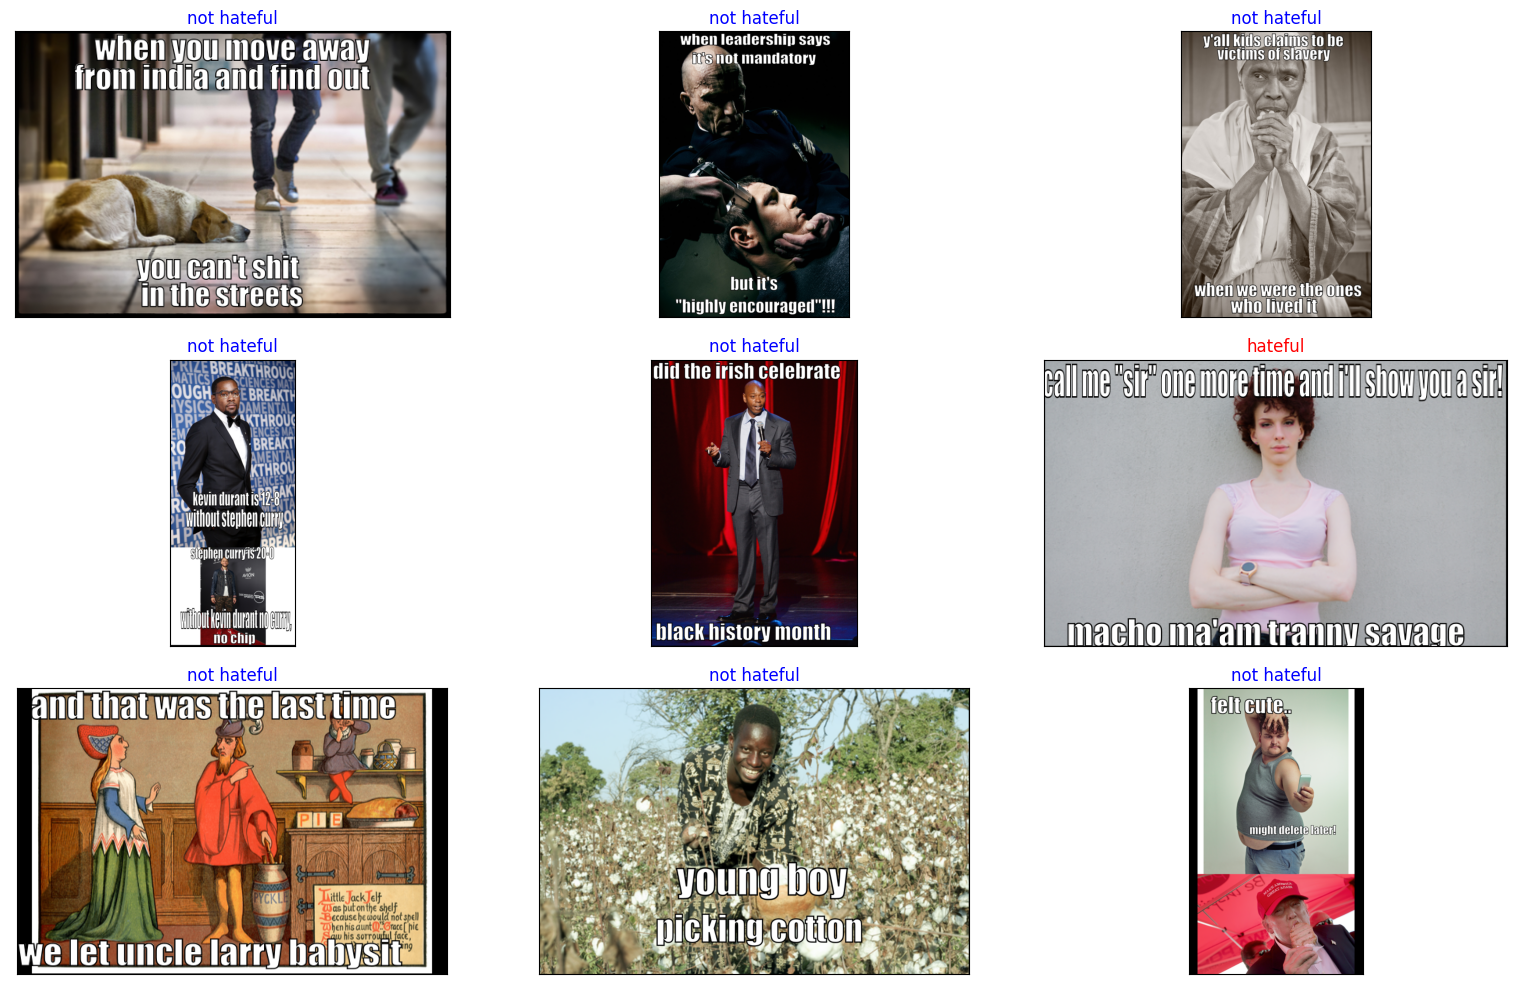

In [ ]:
hm_dataset = HMDataset(
    images_path, f"{annotations_path}/train_updated.jsonl", image_transform=None
)

plt.figure(figsize=(16, 10))

label_map = {1: "hateful", 0: "not hateful"}

for i, idx in enumerate(np.random.random_integers(0, len(hm_dataset), 9)):
    image, text, label = hm_dataset[idx]

    plt.subplot(3, 3, i + 1)
    # C, W, H = image.shape
    # image = image.convert("RGB")
    plt.imshow(image)
    plt.title(label_map[label.item()], color="r" if label else "b")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class HMMLP(nn.Module):
    def __init__(
        self,
        n_in=512 * 2,
        n_out=1,
    ) -> None:
        super().__init__()

        self.fc1 = nn.Linear(n_in, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, n_out)

    def forward(self, x):

        # x = self.fc1(x)
        x = F.dropout(F.relu(self.fc1(x)), p=0.3)
        x = F.dropout(F.relu(self.fc2(x)), p=0.3)
        x = F.dropout(F.relu(self.fc3(x)), p=0.2)
        x = self.fc4(x)

        return x


In [ ]:
batch_size = 32


def text_preprocess(text):
    return clip.tokenize(text, truncate=True)

def get_dataloaders(get_source_data=True):
    if get_source_data:
        train_features_path = None
        test_features_path = None
        val_features_path = None

    else:
        train_features_path = os.path.join(features_path,"train")
        test_features_path = os.path.join(features_path, "test")
        val_features_path = os.path.join(features_path, "val")

    hm_train_dataset = HMDataset(
        images_path,
        f"{annotations_path}/train_updated.jsonl",
        image_transform=preprocess,
        text_transform=text_preprocess,
        features_path=train_features_path,
    )
    hm_test_dataset = HMDataset(
        images_path,
        f"{annotations_path}/test_unseen.jsonl",
        image_transform=preprocess,
        text_transform=text_preprocess,
        features_path=test_features_path,
    )
    hm_val_dataset = HMDataset(
        images_path,
        f"{annotations_path}/dev_unseen.jsonl",
        image_transform=preprocess,
        text_transform=text_preprocess,
        features_path=val_features_path,
    )

    train_dataloader = DataLoader(hm_train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(hm_test_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(hm_val_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader, test_dataloader, val_dataloader


In [ ]:
# train_dataloader, test_dataloader, val_dataloader = get_dataloaders(False)


In [ ]:
train_dataloader, test_dataloader, val_dataloader = get_dataloaders()
data = next(iter(train_dataloader))

In [ ]:
images, texts, labels = data
images.shape, texts.shape, labels.shape


(torch.Size([32, 3, 224, 224]), torch.Size([32, 1, 77]), torch.Size([32]))

In [ ]:
net = HMMLP()
images, texts, labels = data
images = images.to(device)
texts = texts.to(device)
labels = labels.to(device).float()

with torch.no_grad():
    images = model.encode_image(images)
    texts = model.encode_text(texts.squeeze())


In [ ]:
images.shape, texts.shape, labels.shape


(torch.Size([32, 512]), torch.Size([32, 512]), torch.Size([32]))

In [ ]:
net = net.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
optimizer.zero_grad()


In [ ]:
fused = torch.hstack((images, texts))
fused.requires_grad


False

In [ ]:
fused.requires_grad_()
fused.requires_grad


True

In [ ]:
output = net(fused.float())


In [ ]:
output.shape, labels.shape


(torch.Size([32, 1]), torch.Size([32]))

In [ ]:
labels.squeeze()


tensor([1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1.,
        1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1.],
       device='cuda:0')

In [ ]:
output.squeeze(), labels.squeeze()


(tensor([-0.0885, -0.1208, -0.1213, -0.1533, -0.1106, -0.1069, -0.1302, -0.0948,
         -0.1318, -0.1130, -0.1337, -0.1010, -0.1078, -0.1460, -0.1404, -0.0972,
         -0.1233, -0.1041, -0.1267, -0.1143, -0.1350, -0.1289, -0.0884, -0.1223,
         -0.0871, -0.1469, -0.0962, -0.1443, -0.1263, -0.1180, -0.1311, -0.1278],
        device='cuda:0', grad_fn=<SqueezeBackward0>),
 tensor([1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1.,
         1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1.],
        device='cuda:0'))

In [ ]:
o = output.squeeze().round()


In [ ]:
sum(o == labels)


tensor(13, device='cuda:0')

In [ ]:
loss = criterion(output.squeeze(), labels.squeeze())
loss.backward()
optimizer.step()

In [ ]:
net = HMMLP()
net = net.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

epochs = 20
print_every = 50
image_features = torch.Tensor()
text_features = torch.Tensor()
label_features = torch.Tensor()
# labels_train = torch.Tensor()
# fused_images_texts_features_val = torch.Tensor()
# labels_val = torch.Tensor()
data_from_source = True
train_dataloader, test_dataloader, val_dataloader = get_dataloaders(get_source_data=data_from_source)

for epoch in range(epochs):

    running_loss = 0
    for i, data in enumerate(tqdm(train_dataloader), 0):
        images, texts, labels = data
        images = images.to(device)
        texts = texts.to(device)
        labels = labels.float().squeeze().to(device)

        if data_from_source:
            with torch.no_grad():
                images = model.encode_image(
                    images
                )  # input_dim: batch_size x 3 x H x W; output_dim: batch_size x 512
                texts = model.encode_text(
                    texts.squeeze()
                )  # input_dim: batch_size x 77; output_dim: batch_size x 512
        
        if epoch == 0 and data_from_source:
            image_features = torch.cat((image_features, images.cpu().clone().detach()))
            text_features = torch.cat((text_features, texts.cpu().clone().detach()))
            label_features = torch.cat((label_features, labels.cpu().clone().detach()))

        fused_images_texts = torch.hstack((images, texts))
            
        fused_images_texts.requires_grad_()
        fused_images_texts = fused_images_texts.float()

        optimizer.zero_grad()

        # Forward pass on the fused data

        output = net(fused_images_texts)

        loss = criterion(output.squeeze(), labels)

        # Compute gradient
        loss.backward()
        # Update weight
        optimizer.step()

        running_loss += loss.item()

        if i % print_every == (print_every - 1):

            print(
                f"[Epoch {epoch + 1}, step {i+1:3d}] loss: {running_loss/print_every:.5f}"
            )
            running_loss = 0.0

    if epoch == 0 and data_from_source:
        torch.save(
            image_features, os.path.join(features_path, "train", "image_features.pt")
        )
        torch.save(
            text_features, os.path.join(features_path, "train", "text_features.pt")
        )
        torch.save(
            label_features, os.path.join(features_path, "train", "label_features.pt")
        )

    ## Switch to eval mode
    net.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    image_features = torch.Tensor()
    text_features = torch.Tensor()
    label_features = torch.Tensor()
    for i, data in enumerate(tqdm(val_dataloader), 0):

        images, texts, labels = data
        images = images.to(device)
        texts = texts.to(device)
        labels = labels.float().squeeze().to(device)

        if data_from_source:
            with torch.no_grad():
                images = model.encode_image(
                    images
                )  # input_dim: batch_size x 3 x H x W; output_dim: batch_size x 512
                texts = model.encode_text(
                    texts.squeeze()
                )  # input_dim: batch_size x 77; output_dim: batch_size x 512

        if epoch == 0 and data_from_source:
            image_features = torch.cat((image_features, images.cpu().clone().detach()))
            text_features = torch.cat((text_features, texts.cpu().clone().detach()))
            label_features = torch.cat((label_features, labels.cpu().clone().detach()))

        fused_images_texts = torch.hstack((images, texts))

        fused_images_texts.requires_grad_()
        fused_images_texts = fused_images_texts.float()

        with torch.no_grad():
            output = net(fused_images_texts)

        loss = criterion(output.squeeze(), labels)

        running_loss += loss.item()

        correct_preds += sum(torch.sigmoid(output).squeeze().round() == labels)
        total_preds += len(labels)

    print(
        f"[Epoch {epoch +1}, step {i+1:3d}] val loss: {running_loss/i+1:.5f} accuracy: {correct_preds/total_preds}"
    )

    if epoch == 0 and data_from_source:
        torch.save(
            image_features, os.path.join(features_path, "val", "image_features.pt")
        )
        torch.save(
            text_features, os.path.join(features_path, "val", "text_features.pt")
        )
        torch.save(
            label_features, os.path.join(features_path, "val", "label_features.pt")
        )
    net.train()


print("Finished Training!")

  5%|▌         | 14/269 [00:08<02:33,  1.66it/s]


KeyboardInterrupt: 

In [ ]:
images.shape
# texts.shape

torch.Size([32, 3, 224, 224])